# Using LSTM(Window Regression Approach) On Shampoo Sales Dataset

This dataset contains sales for three years(36 months) and it have single independent variable. In this notebook, I tried to use LSTM for predicting sales of first month in 4th year, but due to smaller dataset, mean squared error between actual and predicted output is very high. 

In [1]:
from __future__ import division 

import pandas as pd
import numpy as np
import sklearn 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pandas import datetime
import keras
from keras import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
%matplotlib inline

Using TensorFlow backend.


In [2]:
dataframe = pd.read_csv("../datasets/sales-of-shampoo-over-a-three-ye.csv")
dataframe

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3
5,1-06,168.5
6,1-07,231.8
7,1-08,224.5
8,1-09,192.8
9,1-10,122.9


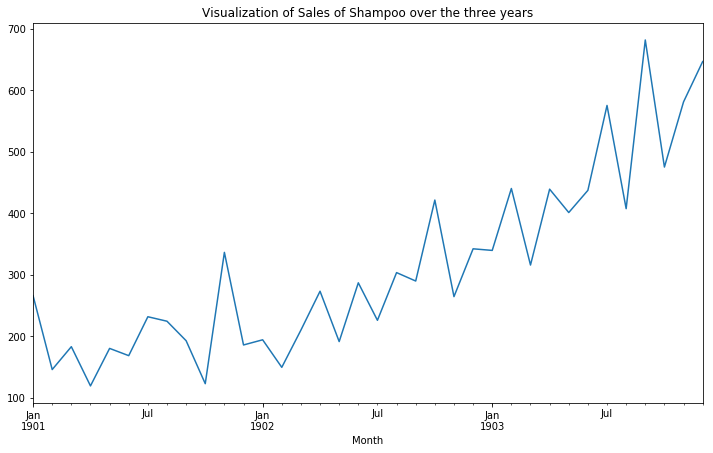

In [3]:
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

dataframe = pd.read_csv('../datasets/sales-of-shampoo-over-a-three-ye.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

dataframe.plot(title="Visualization of Sales of Shampoo over the three years", figsize=(12,7))


In [4]:
# Description of dataset
print dataframe.describe()
print "\n"
# # No undefined values
print "Checking undefined values"
print dataframe.isnull().values.any()

count     36.000000
mean     312.600000
std      148.937164
min      119.300000
25%      192.450000
50%      280.150000
75%      411.100000
max      682.000000
Name: Sales, dtype: float64


Checking undefined values
False


## Prepare the dataset

This includes:

i. Normalization of the feature values

ii. Convert the dataset in the time series(up to certain steps)

iii. Split the dataset into training and test 

### 1. Normalization 

In [5]:
# Preparing the dataset
# normalize the values between 0 and 1
# .fit_Transform function is used to find minimum and maximum values in the data and normalize according to that.
# Since we are normalizing values b/w 0 and 1. 
# So after predictions, we have transform again into original form. If needed, the transform can be inverted. 
# This is useful for converting predictions back into their original scale for reporting or plotting. 
# This can be done by calling the inverse_transform() function
# print dataframe.values.reshape(dataframe.shape[0],1)
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataframe.values.reshape(dataframe.shape[0],1))
scaled_dataframe = pd.DataFrame(scaled_data, columns=['t'])
scaled_dataframe

,t
0,0.260707
1,0.047272
2,0.113382
3,0.000000
4,0.108406
5,0.087436
6,0.199929
7,0.186956
8,0.130620
9,0.006398


### 2. Convert the dataset in the time series

In [6]:
# Window size 
#Fix the moving window size to be 8. 
# For this purpose we use pandas shift function that shifts the entire column by the number we specify. 

# we shifted the column up by 1 (hence used -1. we want to predict future values) 
# If we want to shift it down by 1, we will have to use +1) and then concatenate that to the original data.

window_size = 15
# copied_dataframe = scaled_dataframe.copy()

for i in range(window_size):
    
#     pandas_shift_frame[str(i+1)] = pd.concat([scaled_dataframe, scaled_dataframe['t'].shift(-(i+1))], axis=1)
#     print i
#     scaled_dataframe = pd.concat([scaled_dataframe, copied_dataframe.shift(-(i+1))], axis=1)
    scaled_dataframe["t" + "+" + str(i+1)] = scaled_dataframe["t"].shift(-(i+1))
    
    
print "dataframe for window size of 10"
# scaled_dataframe
scaled_dataframe

dataframe for window size of 10


,t,t+1,t+2,t+3,t+4,t+5,t+6,t+7,t+8,t+9,t+10,t+11,t+12,t+13,t+14,t+15
0,0.260707,0.047272,0.113382,0.000000,0.108406,0.087436,0.199929,0.186956,0.130620,0.006398,0.385996,0.118358,0.133286,0.053670,0.161365,0.273680
1,0.047272,0.113382,0.000000,0.108406,0.087436,0.199929,0.186956,0.130620,0.006398,0.385996,0.118358,0.133286,0.053670,0.161365,0.273680,0.128132
2,0.113382,0.000000,0.108406,0.087436,0.199929,0.186956,0.130620,0.006398,0.385996,0.118358,0.133286,0.053670,0.161365,0.273680,0.128132,0.298027
3,0.000000,0.108406,0.087436,0.199929,0.186956,0.130620,0.006398,0.385996,0.118358,0.133286,0.053670,0.161365,0.273680,0.128132,0.298027,0.189621
4,0.108406,0.087436,0.199929,0.186956,0.130620,0.006398,0.385996,0.118358,0.133286,0.053670,0.161365,0.273680,0.128132,0.298027,0.189621,0.327528
5,0.087436,0.199929,0.186956,0.130620,0.006398,0.385996,0.118358,0.133286,0.053670,0.161365,0.273680,0.128132,0.298027,0.189621,0.327528,0.303181
6,0.199929,0.186956,0.130620,0.006398,0.385996,0.118358,0.133286,0.053670,0.161365,0.273680,0.128132,0.298027,0.189621,0.327528,0.303181,0.537231
7,0.186956,0.130620,0.006398,0.385996,0.118358,0.133286,0.053670,0.161365,0.273680,0.128132,0.298027,0.189621,0.327528,0.303181,0.537231,0.258042
8,0.130620,0.006398,0.385996,0.118358,0.133286,0.053670,0.161365,0.273680,0.128132,0.298027,0.189621,0.327528,0.303181,0.537231,0.258042,0.396304
9,0.006398,0.385996,0.118358,0.133286,0.053670,0.161365,0.273680,0.128132,0.298027,0.189621,0.327528,0.303181,0.537231,0.258042,0.396304,0.391683


In [7]:
# Drop NA values 

scaled_dataframe.dropna(axis=0, inplace=True)
scaled_dataframe

,t,t+1,t+2,t+3,t+4,t+5,t+6,t+7,t+8,t+9,t+10,t+11,t+12,t+13,t+14,t+15
0,0.260707,0.047272,0.113382,0.000000,0.108406,0.087436,0.199929,0.186956,0.130620,0.006398,0.385996,0.118358,0.133286,0.053670,0.161365,0.273680
1,0.047272,0.113382,0.000000,0.108406,0.087436,0.199929,0.186956,0.130620,0.006398,0.385996,0.118358,0.133286,0.053670,0.161365,0.273680,0.128132
2,0.113382,0.000000,0.108406,0.087436,0.199929,0.186956,0.130620,0.006398,0.385996,0.118358,0.133286,0.053670,0.161365,0.273680,0.128132,0.298027
3,0.000000,0.108406,0.087436,0.199929,0.186956,0.130620,0.006398,0.385996,0.118358,0.133286,0.053670,0.161365,0.273680,0.128132,0.298027,0.189621
4,0.108406,0.087436,0.199929,0.186956,0.130620,0.006398,0.385996,0.118358,0.133286,0.053670,0.161365,0.273680,0.128132,0.298027,0.189621,0.327528
5,0.087436,0.199929,0.186956,0.130620,0.006398,0.385996,0.118358,0.133286,0.053670,0.161365,0.273680,0.128132,0.298027,0.189621,0.327528,0.303181
6,0.199929,0.186956,0.130620,0.006398,0.385996,0.118358,0.133286,0.053670,0.161365,0.273680,0.128132,0.298027,0.189621,0.327528,0.303181,0.537231
7,0.186956,0.130620,0.006398,0.385996,0.118358,0.133286,0.053670,0.161365,0.273680,0.128132,0.298027,0.189621,0.327528,0.303181,0.537231,0.258042
8,0.130620,0.006398,0.385996,0.118358,0.133286,0.053670,0.161365,0.273680,0.128132,0.298027,0.189621,0.327528,0.303181,0.537231,0.258042,0.396304
9,0.006398,0.385996,0.118358,0.133286,0.053670,0.161365,0.273680,0.128132,0.298027,0.189621,0.327528,0.303181,0.537231,0.258042,0.396304,0.391683


### Split the dataset for training and testing

In [8]:
split_data = int(round(0.8*scaled_dataframe.shape[0]))
split_data

17

In [9]:
train_data = scaled_dataframe.iloc[:split_data,:]
test_data = scaled_dataframe.iloc[split_data:,:]

# train_data = shuffle(train_data)
train_data


,t,t+1,t+2,t+3,t+4,t+5,t+6,t+7,t+8,t+9,t+10,t+11,t+12,t+13,t+14,t+15
0,0.260707,0.047272,0.113382,0.000000,0.108406,0.087436,0.199929,0.186956,0.130620,0.006398,0.385996,0.118358,0.133286,0.053670,0.161365,0.273680
1,0.047272,0.113382,0.000000,0.108406,0.087436,0.199929,0.186956,0.130620,0.006398,0.385996,0.118358,0.133286,0.053670,0.161365,0.273680,0.128132
2,0.113382,0.000000,0.108406,0.087436,0.199929,0.186956,0.130620,0.006398,0.385996,0.118358,0.133286,0.053670,0.161365,0.273680,0.128132,0.298027
3,0.000000,0.108406,0.087436,0.199929,0.186956,0.130620,0.006398,0.385996,0.118358,0.133286,0.053670,0.161365,0.273680,0.128132,0.298027,0.189621
4,0.108406,0.087436,0.199929,0.186956,0.130620,0.006398,0.385996,0.118358,0.133286,0.053670,0.161365,0.273680,0.128132,0.298027,0.189621,0.327528
5,0.087436,0.199929,0.186956,0.130620,0.006398,0.385996,0.118358,0.133286,0.053670,0.161365,0.273680,0.128132,0.298027,0.189621,0.327528,0.303181
6,0.199929,0.186956,0.130620,0.006398,0.385996,0.118358,0.133286,0.053670,0.161365,0.273680,0.128132,0.298027,0.189621,0.327528,0.303181,0.537231
7,0.186956,0.130620,0.006398,0.385996,0.118358,0.133286,0.053670,0.161365,0.273680,0.128132,0.298027,0.189621,0.327528,0.303181,0.537231,0.258042
8,0.130620,0.006398,0.385996,0.118358,0.133286,0.053670,0.161365,0.273680,0.128132,0.298027,0.189621,0.327528,0.303181,0.537231,0.258042,0.396304
9,0.006398,0.385996,0.118358,0.133286,0.053670,0.161365,0.273680,0.128132,0.298027,0.189621,0.327528,0.303181,0.537231,0.258042,0.396304,0.391683


In [10]:
# Consider last column as output
train_data_x = train_data.iloc[:,:-1]
train_data_y = train_data.iloc[:,-1]
test_data_x = test_data.iloc[:,:-1]
test_data_y = test_data.iloc[:,-1]
print "train features shape ", train_data_x.shape
print "train label shape ", train_data_y.shape
print "test data y ", test_data_y.shape

train features shape  (17, 15)
train label shape  (17,)
test data y  (4,)


# Define Model Parameters

In [11]:
# Reshape it for LSTM 
train_data_x = np.array(train_data_x)
test_data_x = np.array(test_data_x)
# print train_data_x.shape[0], train_data_x.shape[1]
train_data_x = train_data_x.reshape(train_data_x.shape[0],train_data_x.shape[1],1)
test_data_x = test_data_x.reshape(test_data_x.shape[0],test_data_x.shape[1],1)
print "Reshape train example x ", train_data_x.shape
print "Reshape test example x ", test_data_x.shape
input_shape = (window_size,1)
output = window_size

Reshape train example x  (17, 15, 1)
Reshape test example x  (4, 15, 1)


# LSTM Model  Architecture

In [12]:
model = Sequential()
model.add(LSTM(input_shape = input_shape, units= output, return_sequences=True))
# model.add(Dense(128))
# model.add(Dropout(0.5))
model.add(LSTM(128))

model.add(Dropout(0.5))
# model.add(Dense(64))
model.add(Dense(1))
# model.add(Activation(""))
model.compile(loss="mse", optimizer="adam")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 15, 15)            1020      
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               73728     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 74,877
Trainable params: 74,877
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.fit(train_data_x,train_data_y,batch_size=2,epochs=10,validation_split=0.1, shuffle=False)


Train on 15 samples, validate on 2 samples
Epoch 1/10
15/15 [==============================] - 3s 215ms/step - loss: 0.1029 - val_loss: 0.1468
Epoch 2/10
15/15 [==============================] - 0s 16ms/step - loss: 0.0152 - val_loss: 0.0267
Epoch 3/10
15/15 [==============================] - 0s 16ms/step - loss: 0.0280 - val_loss: 0.0988
Epoch 4/10
15/15 [==============================] - 0s 16ms/step - loss: 0.0149 - val_loss: 0.0527
Epoch 5/10
15/15 [==============================] - 0s 17ms/step - loss: 0.0136 - val_loss: 0.0385
Epoch 6/10
15/15 [==============================] - 0s 18ms/step - loss: 0.0195 - val_loss: 0.0448
Epoch 7/10
15/15 [==============================] - 0s 16ms/step - loss: 0.0136 - val_loss: 0.0350
Epoch 8/10
15/15 [==============================] - 0s 17ms/step - loss: 0.0149 - val_loss: 0.0465
Epoch 9/10
15/15 [==============================] - 0s 17ms/step - loss: 0.0141 - val_loss: 0.0480
Epoch 10/10
15/15 [==============================] - 0s 17ms/step

In [14]:
predicted_output = model.predict(test_data_x)
#converting predictions back into their original scale for reporting or plotting.
# print "predicted output shape ", predicted_output.shape
predicted_output_scaled = scaler.inverse_transform(predicted_output)
print predicted_output

[[0.6671108 ]
 [0.7051457 ]
 [0.7447773 ]
 [0.78130674]]


In [15]:
# convert actual to its original form
# test_data_y = test_data_y.values.reshape(-1,1)
test_data_y = test_data_y.reshape(test_data.shape[0],1)
print test_data_y
actual_output_scaled = scaler.inverse_transform(test_data_y)
# actual_output.shape

[[1.        ]
 [0.63266394]
 [0.82104141]
 [0.93762218]]


/home/ramesh/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
print "mean square error ", mean_squared_error(actual_output_scaled,predicted_output_scaled)

mean square error  11582.340908623708


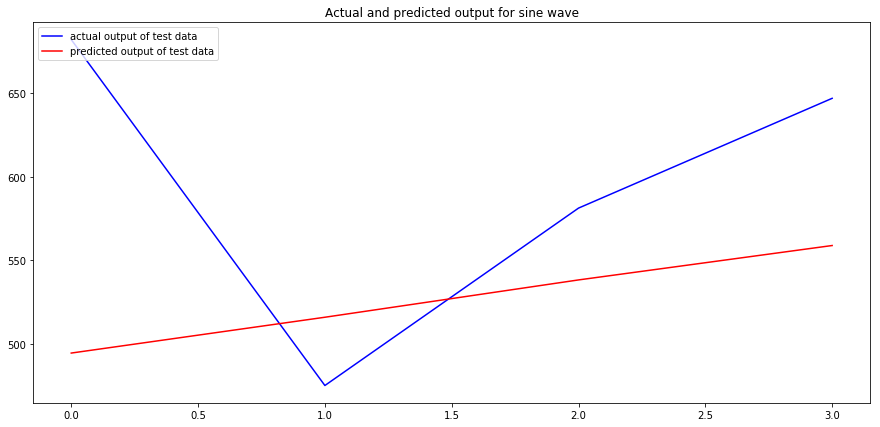

In [17]:
plt.figure(figsize=(15,7))
plt.plot(actual_output_scaled, '-b', label='actual output of test data')
# we just visualize prediction of first 200 points because predicted and actual output overlaps completely
plt.plot(predicted_output_scaled, '-r', label='predicted output of test data')
plt.title("Actual and predicted output for sine wave")
plt.legend(loc='upper left')

## Conclusion:

Due to less number of training examples, model is unable to learn properly and mean square error is very huge